<font size=6><b>[Project]경기국면에 따른 포트폴리오 리밸런싱(Fama French) </b></font>

* <b> Market Premium - Calculated from S&P/TSX Composite Index and 90-day Treasury Bills.
* <b> SMB - Categorized each security as small or large market cap by using 30-70 percentiles of aggregate market cap in portfolio.
* <b> HML - Used inverse of P/B as proxy to catergorize and calculate book to market value.

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
#from sklearn.linear_model import LinearRegression
import scipy, scipy.stats
pd.options.mode.chained_assignment = None  # default='warn'

import plotly.graph_objects as go
import plotly.io as pio
import chart_studio
import plotly.express as px
from plotly.subplots import make_subplots

from pykrx import stock
from pandas_datareader import data  

chart_studio.tools.set_credentials_file(username='opencv.korea', api_key='YKVa3qq0Uq9Xf2JiIX22')

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

plt.rc('font', family='Malgun Gothic')


# 요인모델

* <b>거시경제 요인 모델</b>
    * 관측 가능한 거시경제 변수가 요인으로 사용
    * 시계열 회귀분석 방식
        * 개별 자산의 전기간 수익률, 요인 실현값의 전기간 수익률이 주어져 있고, 시계열 회귀분석을 통해서 요인 베타 추정
* <b>펀더멘털 요인 모델</b>
    * Size, Value, Momentum과 같은 관찰 가능한 자산 고유의 특성을 사용
    * BARRA 접근법(횡단면 회귀분석 방식)
        * 한 시점의 전체 자산들의 수익률, 전체 자산들의 요인 베타가 주어져 있고, 횡단면 회귀분석을 통해서 해당 시점의 요인 실현값 추정
    * Fama-French 접근법(시계열 회귀분석 방식)
        * 요인별로 분위 포트폴리오를 만들어 명시적인 요인 실현값을 먼저 계산
        * 개별 자산의 전기간 수익률, 만들어낸 요인 실현값의 전기간 수익률이 주어져 있는 상태에서, 시계열 회귀분석을 통해서 요인 베타 추정
* <b>통계적 요인 모델</b>
    * 통계 기법인 요인 분석 기법 및 주성분 분석 기법을 사용하는 모델

# 거시경제 요인 모델

## OECD경기선행지표(Composite Leading Indicator, CLI)

* [OECD CLI] : https://data.oecd.org/api/sdmx-json-documentation/
* [AA CLI] : https://data.nasdaq.com/data/OECD/MEI_CLI_LOLITOAA_USA_M-amplitude-adjusted-cli-united-states
* [CLI.csv] : https://data.oecd.org/leadind/composite-leading-indicator-cli.htm
* [기준순환점] : https://www.nber.org/research/data/us-business-cycle-expansions-and-contractions

In [2]:
oecd = pd.read_csv("./dataset/OECD_CLI.csv")
oecd = oecd[oecd['LOCATION']=='KOR'][['TIME','Value']]
oecd.columns = ['rdate','cli']
oecd['rdate'] = pd.to_datetime(oecd['rdate'], format='%Y-%m-%d')
# oecd = oecd.set_index("rdate")
oecd.head()

,rdate,cli
5838,1999-08-01,105.7148
5839,1999-09-01,105.7379
5840,1999-10-01,105.5979
5841,1999-11-01,105.3427
5842,1999-12-01,104.9766


## Amplitude Adjusted (Cli), United States
* 추세 복원 지수(The trend restored CLI) 
    * 경기순환 지표에 장기추세를 복원한 원지수
* 연율 변동 지수(The 12-month rate of change of the CLI) 
    * 추세 복원 지수(The trend restored CLI)의 전년동월 대비 증가율로 경기순환 예측 지표
* <b>진폭 조정 지수(The amplitude adjusted CLI) </b>
    * OECD에서 제공되는 경기선행지수 가운데 가장 일반적으로 사용
    * 장기추세를 제거하고 최근 수치에 가중치를 두는 지수
    * 경기순환(business cycle)의 단계는 다음과 같이 분류
    * 2단계 분류
        * 확장(기준선 100pt 상회)
        * 위축(기준선 100pt 하회)
        * 경기 저점과 고점에 대한 기준순환점을 시후적으로 공표
    * 4단계 분류: 
        * 확장(expansion)- 100pt 상회 + 상승 추이 
        * 둔화(slow down)- 100pt 상회 + 하락 추이
        * 위축(recession)- 100pt 하회 + 하락 추이 
        * 회복(recovery) - 100pt 하회 + 상승 추이
        * 4단계 분류상 기준순환점을 공식적으로 발표하지는 않음<br><br>

In [13]:
oecd2 = pd.read_csv("./dataset/OECD_AA_CLI.csv")
oecd2['rdate'] = pd.to_datetime(oecd2['rdate'])
# oecd2 = oecd2.set_index("rdate")
oecd2.head()

,rdate,cli
0,1998-01-31,100.88
1,1998-02-28,100.82
2,1998-03-31,100.71
3,1998-04-30,100.57
4,1998-05-31,100.40


In [14]:
oecd2 = pd.read_csv("./dataset/OECD_AA_CLI2.csv", parse_dates=['rdate'])
# oecd2['rdate'] = pd.to_datetime(oecd2['rdate'])
# oecd2 = oecd2.set_index("rdate")
oecd2 = oecd2.set_index('rdate')
oecd2.head()

,kor,us,tot
rdate,,,
1999-08-01,105.7,101.2,101.0
1999-09-01,105.7,101.2,101.1
1999-10-01,105.6,101.3,101.3
1999-11-01,105.3,101.3,101.4
1999-12-01,105.0,101.4,101.6


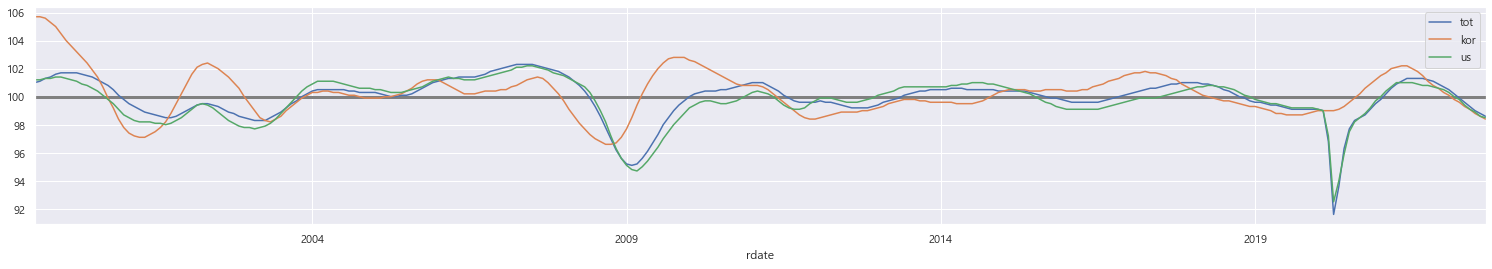

In [15]:
colors = ['','orange','red','blue','skyblue']
ax = oecd2[['tot','kor','us']].plot(figsize=(26,4) )
# for var in mlist:
#     ax.axvspan(df.index[var[0]], df.index[var[1]], color=colors[var[2]], alpha=0.3)
plt.hlines(100, oecd2.index.min(), oecd2.index.max(), color='gray', linestyle='solid', linewidth=3)       

# 국내 경기순환국면(경기싸이클)

<img src="./imgs/img01.png">

<img src="http://db.kookje.co.kr/news2000/photo/2022/0729/L20220729.99099008913i2.jpg" width=400>

## 경기종합지수 순환변동치
* ref : https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1057

In [16]:
cdf = pd.read_csv("./dataset/경기지수.csv", sep="\t")
cdf['rdate'] = pd.to_datetime(cdf['rdate'], format='%Y%m')
cdf = cdf.set_index('rdate')
cdf.head()

,cci,cli
rdate,,
1999-08-01,99.3,104.6
1999-09-01,99.8,104.6
1999-10-01,99.9,104.2
1999-11-01,100.4,104.6
1999-12-01,100.4,104.5


In [17]:
cdf = pd.merge(cdf, oecd2['kor'], left_index=True, right_index=True, how="left")
cdf.head()

,cci,cli,kor
rdate,,,
1999-08-01,99.3,104.6,105.7
1999-09-01,99.8,104.6,105.7
1999-10-01,99.9,104.2,105.6
1999-11-01,100.4,104.6,105.3
1999-12-01,100.4,104.5,105.0


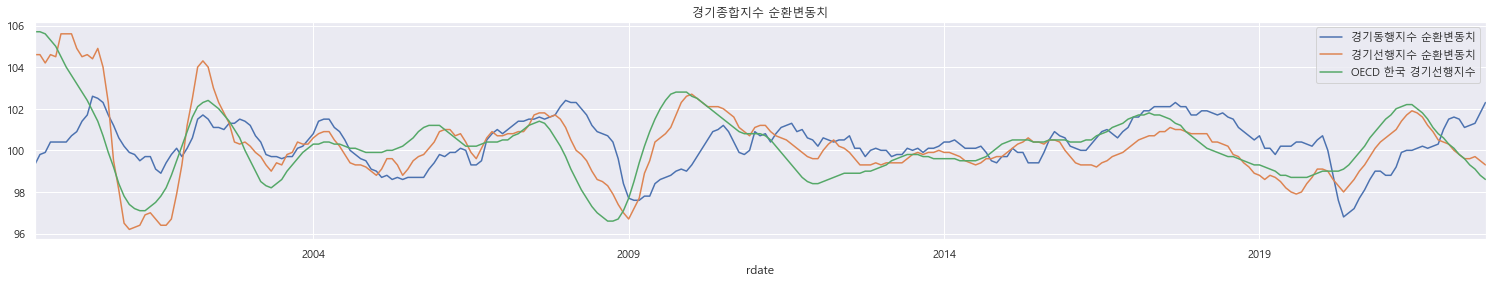

In [18]:
colors = ['','orange','red','blue','skyblue']
cdf.columns = ["경기동행지수 순환변동치","경기선행지수 순환변동치","OECD 한국 경기선행지수"]
ax = cdf[["경기동행지수 순환변동치","경기선행지수 순환변동치","OECD 한국 경기선행지수"]].plot(figsize=(26,4))
# for var in mlist:
#     ax.axvspan(df.index[var[0]], df.index[var[1]], color=colors[var[2]], alpha=0.3)
plt.title("경기종합지수 순환변동치")
plt.legend()
plt.show()

* '경기동행지수 순환변동치'가 상승하는 가운데, '경기선행지수 순환변동치'가 하락하면서 경기회복의 속도가 다소 둔화되는 모습

* <b>문제점</b>
    * '경기동행지수 순환변동치'의 높은 변동성
    * 예) 2010~2011년으로, 경기동행지수의 고점을 식별하기에 어려움이 있음<br>
<img src="./imgs/img02.png" width=500>

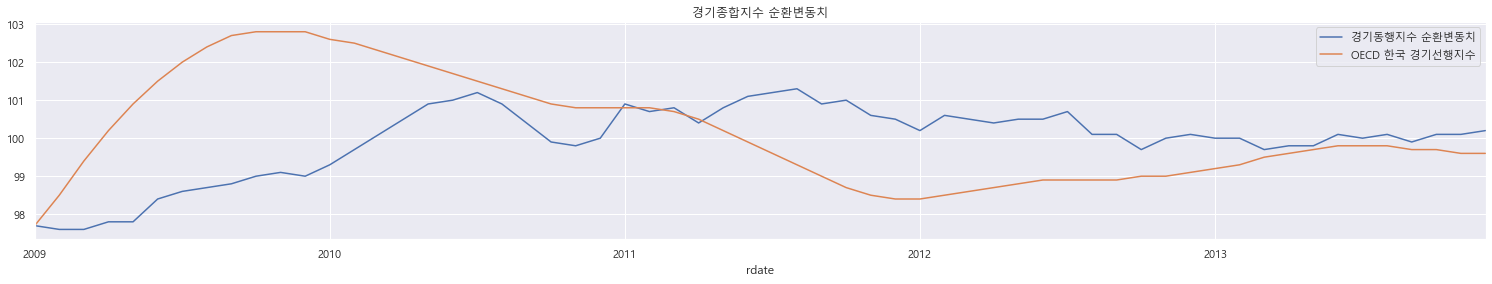

In [19]:
colors = ['','orange','red','blue','skyblue']
ax = cdf.loc['2009':'2013'][["경기동행지수 순환변동치","OECD 한국 경기선행지수"]].plot(figsize=(26,4))
# for var in mlist:
#     ax.axvspan(df.index[var[0]], df.index[var[1]], color=colors[var[2]], alpha=0.3)
plt.title("경기종합지수 순환변동치")
plt.legend()
plt.show()

## 기준순환일
* ref : https://towardsdatascience.com/economic-indicators-with-python-befb8b35af4d

<pre>
#---------------------------------------------
# 미국 기준순환일
#---------------------------------------------
# 1990-07	1991-03	8	92	100	108
# 2001-03	2001-11	8	120	128	128
# 2007-12	2009-06	18	73	91	81
# 2020-02	2020-04	2 	128	130 	146

#---------------------------------------------
# 한국 기준순환일
#---------------------------------------------
# 	           저점	  정점	저점	  확장기	수축기		순환기
# 제1순환기		1972-03	1974-02	1975-06		23		16		39
# 제2순환기		1975-06	1979-02	1980-09		44		19		63
# 제3순환기		1980-09	1984-02	1985-09		41		19		60
# 제4순환기		1985-09	1988-01	1989-07		28		18		46
# 제5순환기		1989-07	1992-01	1993-01		30		12		42
# 제6순환기		1993-01	1996-03	1998-08		38		29		67
# 제7순환기		1998-08	2000-08	2001-07		24		11		35
# 제8순환기		2001-07	2002-12	2005-04		17		28		45
# 제9순환기		2005-04	2008-01	2009-02		33		13		46
# 제10순환기		2009-02	2011-08	2013-03		30		19		49
# 제11순환기		2013-03	2017-09	-		54		-		-


In [20]:
ko_cycle = [['1순환기','1972-03','1974-02','1975-06',23,16,39],
            ['2순환기','1975-06','1979-02','1980-09',44,19,63],
            ['3순환기','1980-09','1984-02','1985-09',41,19,60],
            ['4순환기','1985-09','1988-01','1989-07',28,18,46],
            ['5순환기','1989-07','1992-01','1993-01',30,12,42],
            ['6순환기','1993-01','1996-03','1998-08',38,29,67],
            ['7순환기','1998-08','2000-08','2001-07',24,11,35],
            ['8순환기','2001-07','2002-12','2005-04',17,28,45],
            ['9순환기','2005-04','2008-01','2009-02',33,13,46],
            ['10순환기','2009-02','2011-08','2013-03',30,19,49],
            ['11순환기','2013-03','2017-09','2021-12',54,0,0]]
col_list = ['title','ths','peak','the','exp','rece','recv']
cdf = pd.DataFrame(ko_cycle, columns=col_list)
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   11 non-null     object
 1   ths     11 non-null     object
 2   peak    11 non-null     object
 3   the     11 non-null     object
 4   exp     11 non-null     int64 
 5   rece    11 non-null     int64 
 6   recv    11 non-null     int64 
dtypes: int64(3), object(4)
memory usage: 744.0+ bytes


In [21]:
rdf = pd.DataFrame( {'rdate':pd.date_range('1999-08-01', '2021-12-31', freq='MS'), 'p':0, 't':0})
rdf.head()

,rdate,p,t
0,1999-08-01,0,0
1,1999-09-01,0,0
2,1999-10-01,0,0
3,1999-11-01,0,0
4,1999-12-01,0,0


In [22]:
df = pd.merge(rdf, oecd, how="left", on='rdate')
df.head()

,rdate,p,t,cli
0,1999-08-01,0,0,105.7148
1,1999-09-01,0,0,105.7379
2,1999-10-01,0,0,105.5979
3,1999-11-01,0,0,105.3427
4,1999-12-01,0,0,104.9766


## 경기국면 
* <b>순환적 경기국면 : 한국OECD경기선행지수</b>
    * 경기동행지수와 경기선행지수의 ‘고점’ 혹은 ‘저점’ 판별의 어려움
    * 주식시장의 흐름을 가장 잘 예측하는 변수인 경기선행지수를 기준으로 삼음<p>
* <b> OECD 경기선행지수와 한국 경기순환일를 활용하여 경기국면을 4개로 구분</b>
<pre>   
    # 경기국면     cli          순환변동치경기국면
    # --------------------------------------------------
    # Recovery     100<=cli    전저점->전고점 호황상승
    # Expansion    100>cli     전저점->전고점 호황상승
    # Slowdown     100>cli     전고점->전저점 침체하락
    # Contraction  100>cli     전고점->전저점 침체하락

<img src="https://invest.kiwoom.com/inv/resource/202110/20211007133108000364_883x462_.png">

In [23]:
# df[df['rdate']==pt_points[i]]['pt']
# for s,e in zip(df[df['pt']==1].index,df[df['pt']==-1].index):
#     print(s,e)
# pt_points = ['1999-09-01', '2001-04-01','2002-05-01', '2003-05-01','2007-08-01', '2008-10-01','2009-11-01', '2011-12-01','2017-04-01', '2019-08-01']
# ------------------------------------------------------------------------

p_points = [[1,20] , [33,45], [96,110]  ,[123,148] ,[212,240]]

for p in p_points:
    idx = df[ (df.index>=p[0]) &  (df.index<p[1])  & (df['cli']>=100)].index    # 회복 확장(호황) 둔화(후퇴)  침체 
    df.loc[idx,'cycle'] = -1     
    idx = df[ (df.index>=p[0]) &  (df.index<p[1])  & (df['cli']<100)].index     # 회복 확장(호황) 둔화(후퇴)  침체 
    df.loc[idx,'cycle'] = -2

t_points = [[20,33], [45,96], [110,123] ,[148,212] ,[240, len(df)]]
for p in t_points:
    idx = df[ (df.index>=p[0]) &  (df.index<p[1])  & (df['cli']>=100)].index    # 회복 확장(호황) 둔화(후퇴)  침체 
    df.loc[idx,'cycle'] = 2
    idx = df[ (df.index>=p[0]) &  (df.index<p[1])  & (df['cli']<100)].index     # 회복 확장(호황) 둔화(후퇴)  침체 
    df.loc[idx,'cycle'] = 1

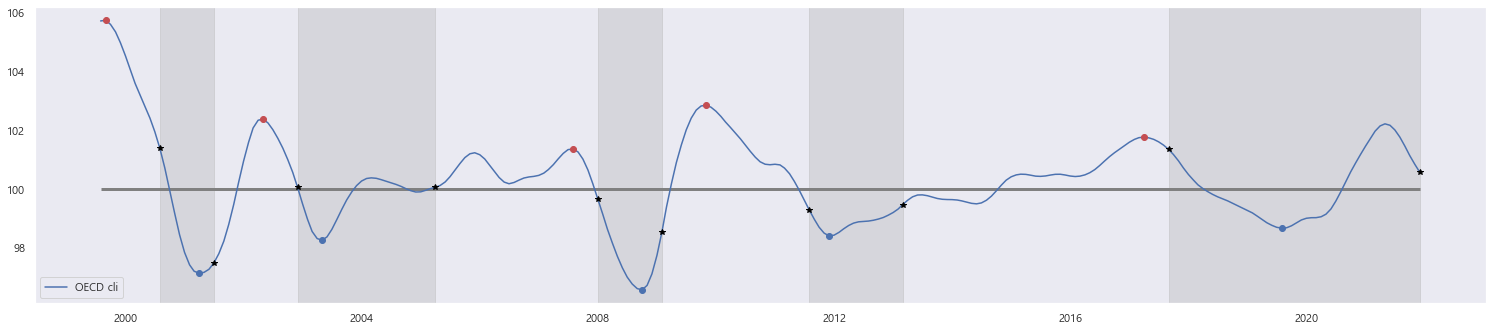

In [24]:
plt.figure(figsize=(26,12))
plt.subplot(211) 
ax = plt.plot(df['rdate'], df['cli'], label="OECD cli")

tlist = [['2000-08-01','2001-07-01'],    #수축:고점->저점
         ['2002-12-01','2005-04-01'],
         ['2008-01-01','2009-02-01'],
         ['2011-08-01','2013-03-01'],
         ['2017-09-01','2021-12-01']]  
plist = [['1998-08-01','2000-08-01'],    #확장:저점->고점
         ['2001-07-01','2002-12-01'],
         ['2005-04-01','2008-01-01'],
         ['2009-02-01','2011-08-01'],
         ['2013-03-01','2017-09-01']]

max_points = []
min_points = []
for i, t in enumerate(tlist):
    maxv = df[(df['rdate']>=plist[i][0]) & (df['rdate']<=plist[i][1])]['cli'].max()
    minv = df[(df['rdate']>=tlist[i][0]) & (df['rdate']<=tlist[i][1])]['cli'].min()
    
    # print("전고(+)", plist[i][0],plist[i][1], maxv)
    idx = df[(df['rdate']>=plist[i][0]) & (df['rdate']<=plist[i][1])& (df['cli']==maxv)].index.values
    # print(idx, df.iloc[idx]['rdate'], maxv)
    max_points.append(idx)
    # print("전저(-)", tlist[i][0],tlist[i][1], minv)
    idx = df[(df['rdate']>=tlist[i][0]) & (df['rdate']<=tlist[i][1])& (df['cli']==minv)].index.values
    # print(idx, df.iloc[idx]['rdate'], minv)
    min_points.append(idx)
    
    df['pt'] = 0
    df.loc[[1,33,96,123,212]  ,'pt'] = 1 
    df.loc[[20,45,110,148,240],'pt'] = -1
    
df.fillna(method='bfill', inplace=True)
    
for i in range(len(tlist)):
    plt.axvspan(pd.to_datetime(tlist[i][0]), pd.to_datetime(tlist[i][1]), color='#aaaaaa', alpha=0.3)        #침체구간
    # plt.axvspan(pd.to_datetime(plist[i][0]), pd.to_datetime(plist[i][1]), color='skyblue', alpha=0.3)     
    plt.plot(pd.to_datetime(tlist[i][0]), df[df['rdate']==tlist[i][0]]['cli'], color='black', marker="*")    #침체구간-시작일
    plt.plot(pd.to_datetime(tlist[i][1]), df[df['rdate']==tlist[i][1]]['cli'], color='black', marker="*")    #침체구간-종료일 
    
    plt.plot(pd.to_datetime(df.loc[max_points[i]]['rdate']), df.loc[max_points[i]]['cli'], 'ro')             #1-Cycle:전고점   
    plt.plot(pd.to_datetime(df.loc[min_points[i]]['rdate']), df.loc[min_points[i]]['cli'], 'bo')             #1-Cycle:전저점
    
plt.hlines(100, df['rdate'].min(), df['rdate'].max(), color='gray', linestyle='solid', linewidth=3)          #CLI 기준선:100 
plt.legend()
plt.grid()
# plt.xticks(x)
# plt.yticks(y)
plt.show()

In [25]:
cycle = df.iloc[0]['cycle']
mlist = []
snum = 0
for i in range(1, len(df)) :
    if  cycle == df.iloc[i]['cycle']:
        continue
    else :
        mlist.append( (snum, i-1, int(df.iloc[i-1]['cycle']))) 
        cycle = df.iloc[i]['cycle']
        snum = i
print(mlist)    

[(0, 13, -1), (14, 19, -2), (20, 27, 1), (28, 32, 2), (33, 40, -1), (41, 44, -2), (45, 51, 1), (52, 62, 2), (63, 66, 1), (67, 95, 2), (96, 100, -1), (101, 109, -2), (110, 115, 1), (116, 122, 2), (123, 141, -1), (142, 147, -2), (148, 182, 1), (183, 211, 2), (212, 224, -1), (225, 239, -2), (240, 252, 1)]


In [26]:
# # df['rdate'] = df["rdate"].dt.strftime("%Y-%m-%d")
df = df.set_index('rdate')  ################################################################################

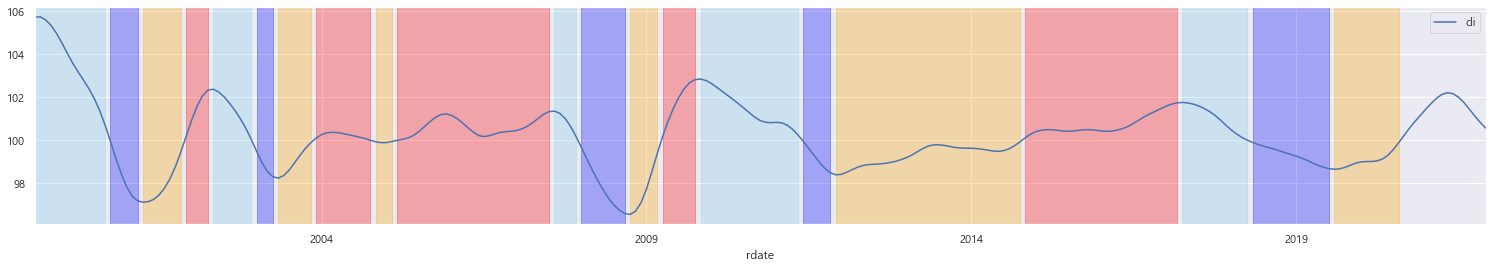

In [27]:
colors = ['','orange','red','blue','skyblue']
ax = df[['cli']].plot(figsize=(26,4) )
for var in mlist:
    ax.axvspan(df.index[var[0]], df.index[var[1]], color=colors[var[2]], alpha=0.3)
# plt.locator_params(axis='x', nbins=len(df)/12)

### 글로벌 금융위기 전후 경기 국면 비중
* OECD  경기선행지수 기준, 

In [28]:
df['cycle'].value_counts().sort_index()

-2.0    40
-1.0    59
 1.0    73
 2.0    97
Name: cycle, dtype: int64

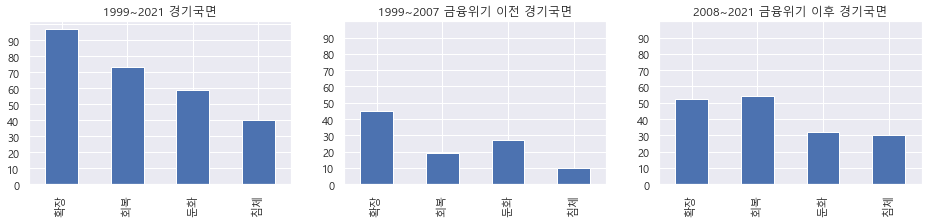

In [29]:
plt.figure(figsize=(16,3))
plt.subplot(131)
df['cycle'].value_counts().sort_index(ascending=False).plot(kind='bar')
plt.title("1999~2021 경기국면")
plt.xticks(np.arange(0, 4), labels=['확장', '회복', '둔화', '침체'])
plt.yticks(np.arange(0, 110, 10), np.arange(0, 100, 10))


plt.subplot(132)
df[(df.index  >= '1999-08-01') & (df.index  <= '2007-12-31')]['cycle'].value_counts().sort_index(ascending=False).plot(kind='bar')
plt.title("1999~2007 금융위기 이전 경기국면")
plt.xticks(np.arange(0, 4), labels=['확장', '회복', '둔화', '침체'])
plt.yticks(np.arange(0, 110, 10), np.arange(0, 100, 10))

plt.subplot(133)
df[(df.index  > '2007-12-31')]['cycle'].value_counts().sort_index(ascending=False).plot(kind='bar')
plt.title("2008~2021 금융위기 이후 경기국면")
plt.xticks(np.arange(0, 4), labels=['확장', '회복', '둔화', '침체'])
plt.yticks(np.arange(0, 110, 10), np.arange(0, 100, 10))
plt.show()

## 성장모멘텀
* 수출지수 증가율, 소비자물가지수 증가율, 기준금리


### 수출지수 증가율(동행)

In [30]:
exp_df = pd.read_csv("./dataset/수출지수.csv", sep="\t", parse_dates=['rdate'])
exp_df = exp_df[(exp_df['rdate']>='1999-08-01') & (exp_df['rdate']<='2021-12-01')]   #경기국면 시작일 '1999-08-01'
# exp_df['pct'] = exp_df['exp'].pct_change()*100
exp_df = exp_df.set_index('rdate')
# exp_df.fillna(method="bfill", inplace=True)
exp_df.head()

,exp
rdate,
1999-08-01,26.64
1999-09-01,28.41
1999-10-01,32.11
1999-11-01,32.49
1999-12-01,33.17


In [31]:
dfq = exp_df.resample(rule='Q').mean()
dfq['shift'] = dfq['exp'].shift(4)
dfq['pct'] = (dfq['exp'] - dfq['shift']) / dfq['exp'] *100
dfq.dropna(inplace=True)   #----------------- 2000-09-30
dfq.head()                 

,exp,shift,pct
rdate,,,
2000-09-30,35.283333,27.525000,21.988663
2000-12-31,35.133333,32.590000,7.239089
2001-03-31,30.440000,30.716667,-0.908892
2001-06-30,29.330000,33.846667,-15.399477
2001-09-30,27.806667,35.283333,-26.888036


In [32]:
dd = df[['cli']].resample(rule='Q').mean()
dd = dd[4:]   #----------------- 2000-09-30
dd.head(10)

,cli
rdate,
2000-09-30,101.342700
2000-12-31,99.178580
2001-03-31,97.476107
2001-06-30,97.175920
2001-09-30,97.822963
2001-12-31,99.481883
2002-03-31,101.529833
2002-06-30,102.314700
2002-09-30,101.703500


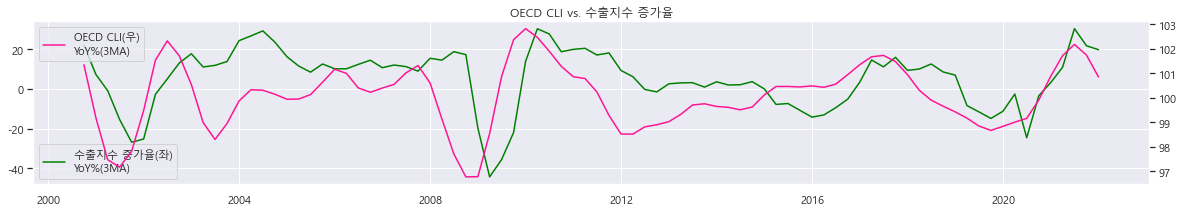

In [33]:
fig, ax1 = plt.subplots(figsize=(20,3))
ax1.plot(dfq.index, dfq['pct'], color='green', label="수출지수 증가율(좌)\nYoY%(3MA)")
plt.legend()
ax2 = ax1.twinx()
ax2.plot(dd.index, dd['cli'], color='deeppink', label="OECD CLI(우)\nYoY%(3MA)")
plt.grid(False)
plt.legend()
plt.title("OECD CLI vs. 수출지수 증가율")
plt.show()


### 소비자물가지수 증가율(후행)

In [34]:
cpi_df = pd.read_csv("./dataset/소비자물가지수.csv", sep="\t", parse_dates=['rdate'])
cpi_df = cpi_df[cpi_df['rdate']>='1999-08-01']   #경기국면 시작일 '1999-08-01'
cpi_df = cpi_df.set_index('rdate')
cpi_df['diff'] = cpi_df.pct_change()
cpi_df.fillna(method="bfill", inplace=True)
cpi_df.head()

,cpi,diff
rdate,,
1999-08-01,61.765,0.002526
1999-09-01,61.921,0.002526
1999-10-01,62.389,0.007558
1999-11-01,62.284,-0.001683
1999-12-01,62.180,-0.001670


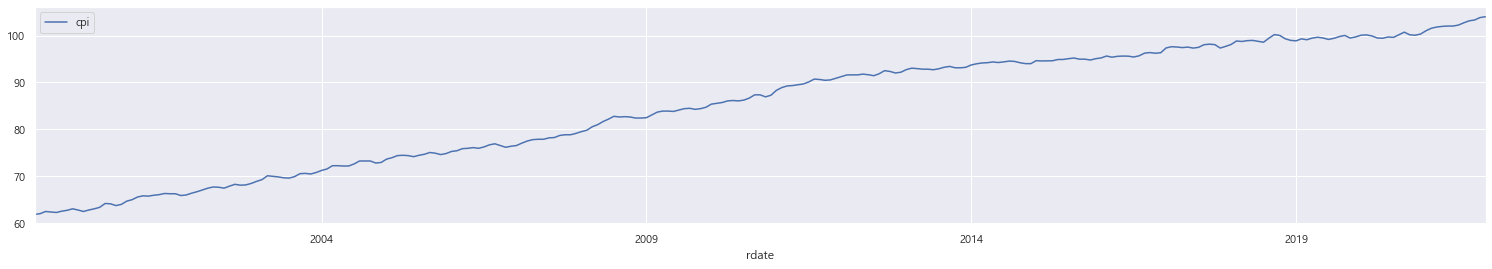

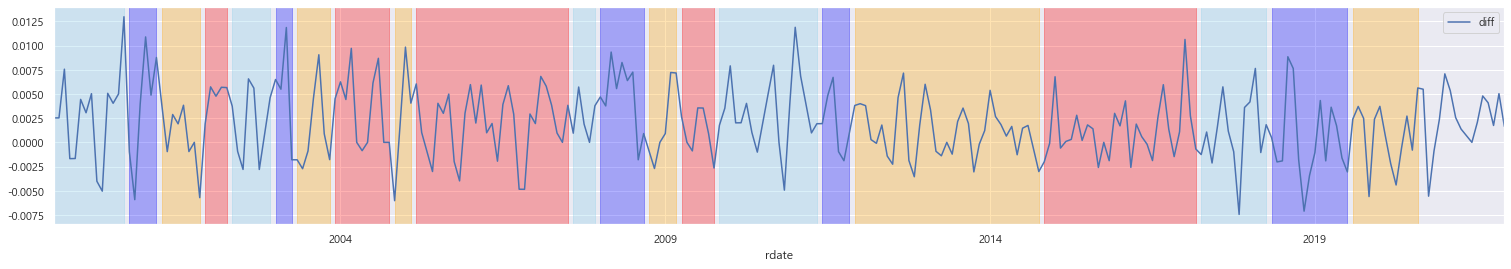

In [35]:
colors = ['','orange','red','blue','skyblue']
ax = cpi_df[['cpi']].plot(figsize=(26,4) )
ax = cpi_df[['diff']].plot(figsize=(26,4) )
for var in mlist:
    ax.axvspan(df.index[var[0]], df.index[var[1]], color=colors[var[2]], alpha=0.3)

### 기준금리

In [36]:
br_df = pd.read_csv("./dataset/한국은행기준금리.csv", sep="\t", parse_dates=['rdate'])
br_df = br_df.set_index('rdate')
br_df.head()

,krate
rdate,
1999-08-01,4.75
1999-09-01,4.75
1999-10-01,4.75
1999-11-01,4.75
1999-12-01,4.75


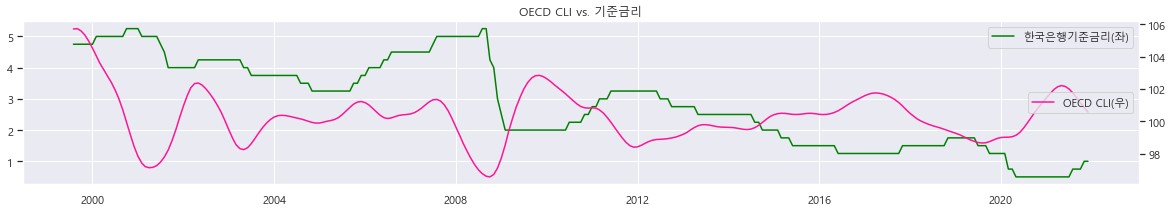

In [37]:
fig, ax1 = plt.subplots(figsize=(20,3))
ax1.plot(br_df.index, br_df['krate'], color='green', label="한국은행기준금리(좌)")
plt.legend(loc="left")
ax2 = ax1.twinx()
ax2.plot(df.index, df['cli'], color='deeppink', label="OECD CLI(우)")
plt.grid(False)
plt.legend(loc="right")
plt.title("OECD CLI vs. 기준금리")
plt.show()


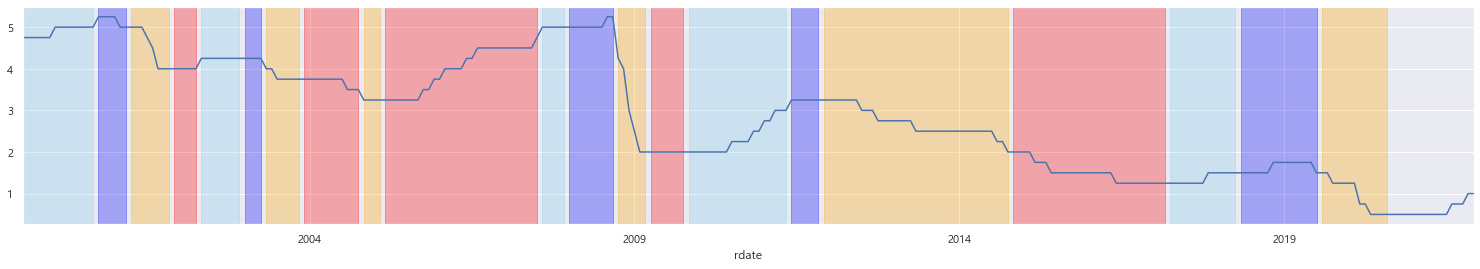

In [38]:
colors = ['','orange','red','blue','skyblue']
ax = br_df['krate'].plot(figsize=(26,4) )
for var in mlist:
    ax.axvspan(df.index[var[0]], df.index[var[1]], color=colors[var[2]], alpha=0.3)
# plt.locator_params(axis='x', nbins=len(df)/12)

### KOSPI 지수

In [41]:
import FinanceDataReader as fdr
pd.options.display.float_format = '{:.1f}'.format

# kospi = fdr.DataReader('KS11',start="1999")
kospi = data.get_data_yahoo("^KS11")[['Adj Close']] 
kospi.index.names = ['rdate']
# kospi = kospi[kospi.index>='1999-08-01']   #경기국면 시작일 '1999-08-01'
# kospi['pct'] = kospi.pct_change()
# 1) 일간 변동률 계산 (t.close - t.close.shift(1)) / t.close.shift(1) * 100
kospi['daily_change'] = (kospi['Adj Close'] - kospi['Adj Close'].shift(1)) / kospi['Adj Close'] * 100
# 2) 누적 합계 계산
kospi['cumsum'] = kospi['daily_change'].cumsum()
kospi.fillna(method="bfill", inplace=True)
kospi.head()

,Adj Close,daily_change,cumsum
rdate,,,
2017-11-09,2550.6,-0.3,-0.3
2017-11-10,2542.9,-0.3,-0.3
2017-11-13,2530.4,-0.5,-0.8
2017-11-14,2526.6,-0.1,-0.9
2017-11-15,2518.2,-0.3,-1.3


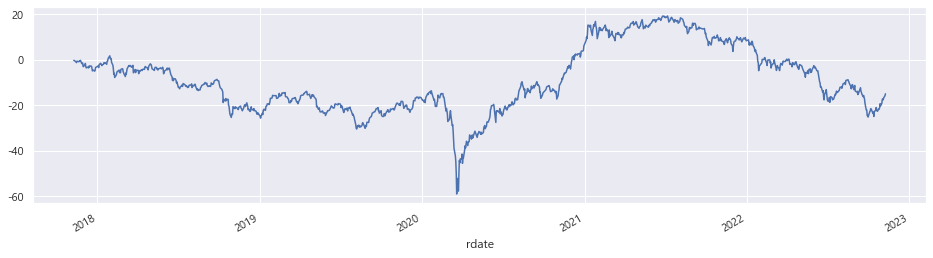

In [42]:
kospi['cumsum'].plot(figsize=(16, 4))
plt.show()

In [68]:
temp = pd.DataFrame(kospi['cumsum'].resample(rule='MS').mean())
temp = pd.merge(temp, br_df, left_index=True, right_index=True, how='left')
temp.head()

,cumsum,krate
rdate,,
2017-11-01,-1.0,1.5
2017-12-01,-3.4,1.5
2018-01-01,-1.3,1.5
2018-02-01,-4.7,1.5
2018-03-01,-4.3,1.5


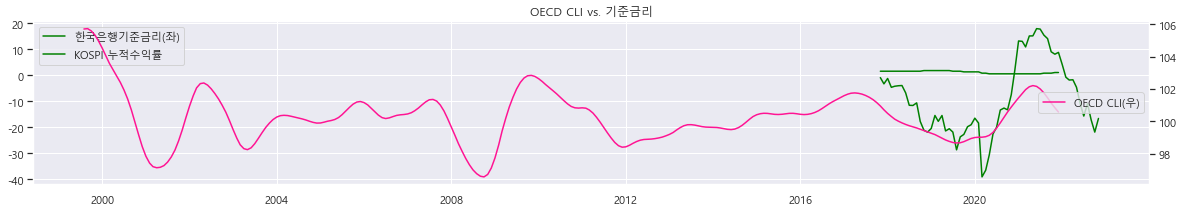

In [69]:
fig, ax1 = plt.subplots(figsize=(20,3))
ax1.plot(temp.index, temp['krate'], color='green', label="한국은행기준금리(좌)")
ax1.plot(temp.index, temp['cumsum'], color='green', label="KOSPI 누적수익률")
plt.legend(loc="left")
ax2 = ax1.twinx()
ax2.plot(df.index, df['cli'], color='deeppink', label="OECD CLI(우)")
plt.grid(False)
plt.legend(loc="right")
plt.title("OECD CLI vs. 기준금리")
plt.show()


* [kiwoom] https://invest.kiwoom.com/inv/27945

<table>
    <tr>
        <td><img src="https://invest.kiwoom.com/inv/resource/202110/20211007132457000524_863x881_.png"></td>
        <td><img src="https://invest.kiwoom.com/inv/resource/202110/20211007132501000066_902x431_.png"></td>
    </tr>
</table>

### 나스닥 지수

In [39]:
import FinanceDataReader as fdr
nas = fdr.DataReader('NASDAQCOM', data_source='fred')
nas.columns = ["nasdaq"]
nas.index.names = ['rdate']
nas = nas[nas.index>='1999-08-01']   #경기국면 시작일 '1999-08-01'
nas['diff'] = nas.pct_change()
nas.fillna(method="bfill", inplace=True)
nas.head()

,nasdaq,diff
rdate,,
1999-08-02,2623.63,-0.013584
1999-08-03,2587.99,-0.013584
1999-08-04,2540.00,-0.018543
1999-08-05,2565.83,0.010169
1999-08-06,2547.97,-0.006961


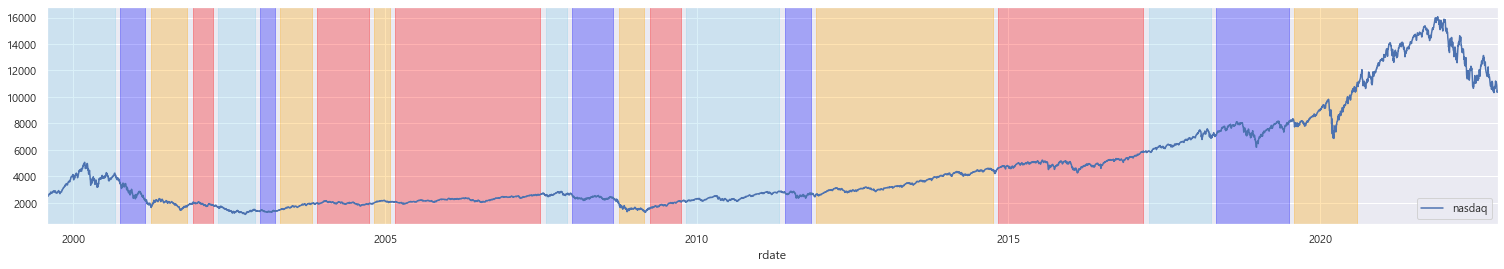

In [40]:
colors = ['','orange','red','blue','skyblue']
ax = nas[['nasdaq']].plot(figsize=(26,4) )
for var in mlist:
    ax.axvspan(df.index[var[0]], df.index[var[1]], color=colors[var[2]], alpha=0.3)

In [ ]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots


# fig = make_subplots(specs=[[{"secondary_y": True}]])

# fig.add_trace(  
#     go.Scatter(x=oecd.index, y=oecd['cli'], name="OECD CLI"),
#     secondary_y=False,
# )
# # fig.add_trace(
# #     go.Scatter(x=nas.index, y=nas['nasdaq'], name="Nasdaq"),
# #     secondary_y=True,
# # )

# fig.update_layout(
#     title_text="OECD Amplitude Adjusted CLI"
# )

# # Set x-axis title
# fig.update_xaxes(title_text="Time")

# # Set y-axes titles
# fig.update_yaxes(title_text="OECD CLI", secondary_y=False)
# # fig.update_yaxes(title_text="NasDaq", secondary_y=True)

# fig.show()

# MSCI Korea
* https://kr.investing.com/indices/msci-korea-historical-data

# MKF 지수
* 유통주식비율(Free Float Rate)을 반영한 시가총액 방식 지수
* <b>MKF 경기방어주 vs. 경기민감주 구분 방식</b>
    * 산업별로 KOSPI 대비 초과수익 월수를 계산(A)
    * 증시 대세 상승국면(‘04.17~’07.7, ‘09.4~’11.4)에 초과성과를 기록한 개월 수(B)를 더해 산업별 랭킹을 계산(A+B) 
    * 상위 랭킹 20개업종이 경기민감업종<p>
* <b>MKF 가치주 vs. 성장주 구분 요소</b>
    
<pre><font size=2>
Style   Factor                       산출방법
---------------------------------------------------------------------------------------------------------------------------------------
Value   B/P                          최근 사업(분기/반기)보고서 상에 기재된 Book Value(자본총계무형자산+자기주식)를 시가총액으로 나누어 산출
        S/P                          최근 4분기 누적 매출액을 시가총액으로 나누어 산출
        CF/P                         최근 4분기 누적 현금흐름(당기순이익+현금유출이 없는 비용현금유입이 없는 수익)을 시가총액으로 나누어 산출
        D/P                          최근 사업보고서상에 기재된 배당금을 시가총액으로 나누어 산출
        12 Month Fwd E/P             2개년 추정실적(FY1, FY2)을 기간 가중하여 산출한 12개월 Forward Earnings를 시가총액으로 나누어 산출
---------------------------------------------------------------------------------------------------------------------------------------
Groth   5year EPS Growth Trend       과거 5개년 EPS의 Growth Trend를 산출
        5year SPS Growth Trend       과거 5개년 SPS의 Growth Trend를 산출
        3year Internal Growth Rate   ROE*(1-Payout Ratio), ROE와 Payout Ratio는 3개년 산술평균
        3year Fwd EPS Growth Trend   추정 3개년 EPS의 Growth Trend를 산출
        3year Fwd SPS Growth Trend   추정 3개년 SPS의 Growth Trend를 산출

# Outlier 처리
* 배당성장 및 Low Vol 등 특정 스타일이 지속적으로 시장을 Outperform
    * 앞으로도 지속적인 성과 우위가 나타날 것인지 예측할 수 없기에, 절대 수익률만 봐서는 정확한 판단이 어려움
    * 과거의 평균수익률(6MA)를 기준으로 경기국면별 상대 성과 측정

# 업종 & 섹터 산출
* ref : https://wg-cy.tistory.com/104?category=1023254

In [93]:
# FinanceDataReader 사용시 설정
import FinanceDataReader as fdr

# KRX 종목전체, KOSPI 코스피종목, KOSDAQ 코스닥종목
stock_code= fdr.StockListing('KRX')[['Symbol','Market','Name','Sector','Industry']]
print('종목개수:', len(stock_code)) # 종목개수 확인
# stock_code.to_excel('./종목코드모음.xlsx') # 엑셀파일로 저장
stock_code.head()

종목개수: 7645


,Symbol,Market,Name,Sector,Industry
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어
1,105190,KOSPI,ACE 200,NaN,NaN
2,332500,KOSPI,ACE 200TR,NaN,NaN
3,385590,KOSPI,ACE ESG액티브,NaN,NaN
4,380340,KOSPI,ACE Fn5G플러스,NaN,NaN


In [108]:
import FinanceDataReader as fdr
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

ohlcv_df = pd.DataFrame()
for stock in ['001440', '005930']:
    close = pdr.get_data_yahoo(f'{stock}.KS',start='1999-08-01', end='2022-09-30')['Adj Close']
    ohlcv_df[f'{stock}'] = close 
ohlcv_df.head(5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,001440,005930
Date,,
2000-01-04,197037.1,4591.9
2000-01-05,186166.1,4193.6
2000-01-06,171218.4,4223.7
2000-01-07,173256.7,4163.5
2000-01-10,172577.3,4336.4


In [72]:
df = stock.get_market_fundamental("20210104", "20220930", "005930")
print(df.head(2))

              BPS  PER  PBR   EPS  DIV   DPS
날짜                                          
2021-01-04  37528 26.2  2.2  3166  1.7  1416
2021-01-05  37528 26.5  2.2  3166  1.7  1416


In [78]:
tickers = stock.get_market_ticker_list("20220930", market="ALL")
len(tickers)        

2651

In [90]:
tlist = []
for ticker in stock.get_market_ticker_list("20220930", market="KOSPI"):
    ticker_name = stock.get_market_ticker_name(ticker)
    tlist.append((ticker, ticker_name))
tlist[:5]

[('095570', 'AJ네트웍스'),
 ('006840', 'AK홀딩스'),
 ('027410', 'BGF'),
 ('282330', 'BGF리테일'),
 ('138930', 'BNK금융지주')]

In [ ]:
ohlcv_list = []
for ticker in tlist:
    ohlcv = stock.get_market_ohlcv(ticker)['종가']
    
    

# KOR_FF 
* https://invest-in-yourself.tistory.com/300

# CAPM vs. Three Factor Model
* <b>CAPM</b>
    * 주가의 기대수익률을 결정하는 요인 : MarketRisk
    * 기대수익률 = 무위험수익률 + (시장기대수익률 – 무위험수익률)*<font color=red><b>베타</b> --> 개별 기업의 성과를 설명하기 역부족</font>
        *  베타 : 시장 변동성에 대한 일종의 민감도로, 값이 클수록 위험 및 기대수익률은 높아진다
* <b>Fama French Three Factor Model</b>
    * 1992년 파마 교수와 케네스 프렌치(Kenneth French) 교수가 제시
    * CAPM의 한계점 보안
    * 주가의 기대수익률을 결정하는 요인 : Market Risk + Size Risk, Value Risk<p><p>
    * <font color=red><b>시가총액이 작고(중소형주), 장부가치/시가총액이 낮은 종목일수록 초과수익을 올리기에 유리</b></font>
-----    
<img src="./imgs/img03.png" width=600>    

In [ ]:
import requests as rq
from io import BytesIO
import pandas as pd


gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
gen_otp_data = {
  #'mktId': 'KSQ', #'STK',
  'mktId': 'STK',
  'trdDd': '20211212',
  'money': '1',
  'csvxls_isNo': 'false',
  'name': 'fileDown',
  'url': 'dbms/MDC/STAT/standard/MDCSTAT03901'
}

# 헤더 부분에 리퍼러(Referer) 추가
headers = {'Referer': 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader'}
otp = rq.post(gen_otp_url, gen_otp_data, headers=headers).text
down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
down_sector_KS  = rq.post(down_url, {'code':otp}, headers=headers)
sector_KS = pd.read_csv(BytesIO(down_sector_KS.content), encoding='EUC-KR')

# 종목코드, 종목명, 시장구분
sector_KS = sector_KS[['종목코드', '종목명', '시장구분','업종명']]
sector_KS.rename(columns = {'종목코드' : 'code'}, inplace = True)
sector_KS.rename(columns = {'종목명' : 'company'}, inplace = True)
sector_KS.rename(columns = {'시장구분' : 'market'}, inplace = True)
sector_KS.rename(columns = {'업종명' : 'sector'}, inplace = True)
sector_KS.head()


In [ ]:
# sector_KS.groupby('sector')['시가총액'].max()

In [ ]:
sector_KS['sector'].value_counts()

# 경기순환과 투자스타일의 관계

# 경기국면별 스타일 절대성과

## 경기확장국면에는 어떤 투자 스타일이 유망한가?
* 경기확장국면에는 가치(Value)와 경기민감(Cyclical) 스타일이 Outperform
* 경기확장이 본격화되는 가운데 시장수익률도 6개월 Rolling Average 기준으로 18.9% 기록
* 반면 경기방어(Non-Cyclical)와 저변동성(Low Vol)은 상대적으로 부진

* 경기확장국면의 주요 투자스타일 성과(6개월 수익률 기준)

## 경기정점에는 어떤 투자 스타일이 유망한가?
* 경기정점에는 경기방어(Non-Cyclical) 및 저변동성(Low Vol) 스타일이 Outperform
* 경기정점 우려로 주식 투자 성과가 낮아지는 가운데, 중소형주(Mid-small)가 상대적으로 부진했음

## 경기수축국면에는 어떤 투자 스타일이 유망한가? 
* 경기수축국면에는 가치주(Value) 및 저변동성(Low Vol) 스타일이 Outperform
* 경기민감주(Cyclical)과 성장주(Growth)가 Underperform

## 경기저점에는 어떤 투자 스타일이 유망한가? 
* 경기저점에는 가치주(Value) 및 중소형주(Mid-small) 스타일이 Outperform
* 경기 바닥에 대한 기대감으로 투자 성과가 개선되나, 상대적으로 성장주(Growth)와 경기민감주(Cyclical) 약세

# 경기국면별 스타일 상대성과


##  경기확장국면에는 어떤 투자 스타일이 유망한가?
* Value 및 Cyclical이 경기확장국면에 (과거 수익률 대비) 성과가 뛰어난 것으로 나타남
* 반면 Non-Cyclical과 Low Vol은 상대적으로 부진

* 경기확장국면의 주요 투자스타일 성과(과거 수익률 대비)

## 경기정점에는 어떤 투자 스타일이 유망한가? 
* 경기정점에는 Non-Cyclical 및 Growth 스타일이 (과거 수익률 대비) Outperform
* 반면 Value와 High Yield, 그리고 Mid-small 유형이 상대적으로 부진

* 경기정점의 주요 투자스타일 성과(과거 수익률 대비)

## 경기수축국면에는 어떤 투자 스타일이 유망한가? 
* 경기수축국면에는 Non-Cyclical과 Low Vol 유형이 Outperform
* 반면 Growth와 Cyclical 부진

* 경기수축국면의 주요 투자스타일 성과(과거 수익률 대비) 

## 경기저점에는 어떤 투자 스타일이 유망한가?
* 경기저점에는 Mid-small 및 Non-Cyclical 스타일의 상대성과 돋보여
* 반면 Value와 Cyclical의 부진이 두드러짐

* 경기저점의 주요 투자스타일 성과(과거 수익률 대비)

# 포트폴리오 전략

##   경기확장국면이 지속된다면?
* 향후 1년 이상 지속될 것으로 예상될 때에는 Value Style 포트폴리오 유망
* 가치주 포트폴리오 내에 금융 및 경기민감소비재 업종비중이 과다하다고 느낄 경우 Cyclical 포트폴리오가 대안

## 경기확장을 낙관하지만, Value Style이 부담스럽다면?
* 경기확장 국면의 지속 가능성을 높게 보지만, 가치주 투자가 부담스러운 투자자들에게는 Cyclical Style 포트폴리오가 대안이 될 수 있음


## 경기정점에 곧 도달할 것으로 예상한다면?
* 경기확장 국면의 지속 가능성을 높게 보지만, 가치주 투자가 부담스러운 투자자들에게는 Cyclical Style 포트폴리오가 대안이 될 수 있음


## 경기정점에 곧 도달할 것으로 예상한다면?
*  6~12개월 내 경기정점 도달 가능성이 높다고 본다면, Growth 스타일 비중을 높일 필요가 있음

## 경기 여건은 비관하나 Growth Style이 부담스러운 투자자는? 
* 향후 경기를 비관하지만, Growth 포트폴리오가 특정 섹터에 편중되었다고 느끼는 투자자들에게는 Non-Cyclical이 대안이 될 수 있음